In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline


In [3]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta


(1460, 81) (1459, 80)


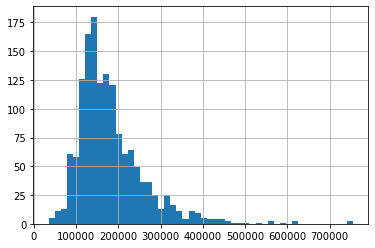

In [4]:
#make train and test datasets. Splitting labels and features happens later
path_train = "https://raw.githubusercontent.com/jvanelteren/housing/master/datasets/train.csv"
path_test = "https://raw.githubusercontent.com/jvanelteren/housing/master/datasets/test.csv"

train = pd.read_csv(path_train)
final_test = pd.read_csv(path_test)
print(train.shape, final_test.shape)

y_col = (set(train.columns) - set(final_test.columns)).pop()


train_x = train.drop([y_col], axis=1)
train_y = train.loc[:,y_col]

corr = train.corr()[y_col]
corr = corr.sort_values(ascending=False)
num_x = list(corr.index)[1:]

cat_x = [col for col in final_test.columns if final_test[col].dtype == 'object']
cat_x.sort(key = lambda x: -correlation_ratio(train[x],train[y_col]))

train[y_col].hist(bins=50)

Skewness: 1.882876
Skewness: 0.121347


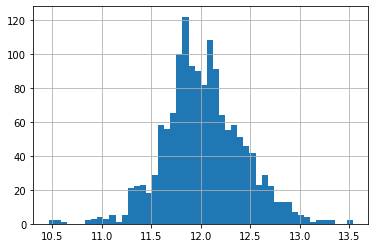

In [28]:
print("Skewness: %f" % train[y_col].skew())
train[y_col] = np.log1p(train[y_col])
print("Skewness: %f" % train[y_col].skew())
train[y_col].hist(bins=50)

### Preprocessing

In [29]:


def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

cat_x = [(col,round(-correlation_ratio(train[col],train[y_col]),2)) for col in final_test.columns if final_test[col].dtype == 'object']
cat_x.sort(key = lambda x: x[1])
print('Categorical features with highest correlation ratio')
cat_x[:10]

Categorical features with highest correlation ratio


[('Neighborhood', -0.76),
 ('ExterQual', -0.68),
 ('KitchenQual', -0.67),
 ('BsmtQual', -0.64),
 ('Foundation', -0.55),
 ('GarageFinish', -0.52),
 ('HeatingQC', -0.48),
 ('GarageType', -0.48),
 ('MasVnrType', -0.44),
 ('Exterior1st', -0.43)]

In [30]:
corr = train.corr()[y_col]
corr = corr.sort_values(ascending=False)
print('Numeric features with highest correlation')
corr[:10]

Numeric features with highest correlation


SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: SalePrice, dtype: float64

## Exploration: Quantitative Variables

In [33]:
from altair.expr import datum
def gen_chart(name):
    return alt.Chart(path_train).mark_point(
        color='red',
        opacity=0.1,
        size=1
    ).encode(
        x= alt.X(name+':Q',scale=alt.Scale(zero=False)) ,
        y='SalePrice:Q'
    ).properties(
        width=150,
        height=150
    )

#create a list of subplots
subplts = []
for name in num_x:
    subplts.append(gen_chart(name))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

## Exploration: Quantitative Variables interactive chart

In [35]:
import altair as alt
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(path_train).mark_point(        opacity=0.1,
        size=2).encode(
    y='SalePrice:Q',
    color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray')),
).add_selection(
    brush
).properties(
    width=140,
    height=140
)
num_x.append('SalePrice')
subplts = []
for name in num_x:
    subplts.append(base.encode(alt.X(name+':Q',scale=alt.Scale(zero=False))))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

In [6]:
## Exploration: Categorical Variables

In [0]:
def gen_chart(name):
  chart = alt.Chart(url).mark_bar().encode(
        x= alt.X(name+':N', bin=False),
        y='count()',
        color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray'))
    ).properties(
        width=140,
        height=30
    ).add_selection(
    brush)

  price = alt.Chart(url).mark_boxplot().encode(
        x= alt.X(name+':N'),
        y='SalePrice:Q',
        color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray'))
    ).properties(
        width=140,
        height=140
    ).add_selection(
    brush)
  return price & chart

brush = alt.selection(type='interval', resolve='global')
#create a list of subplots
subplts = []
for name in cat_x:
    subplts.append(gen_chart(name))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

In [18]:
train_x['YearBuilt'].describe()

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

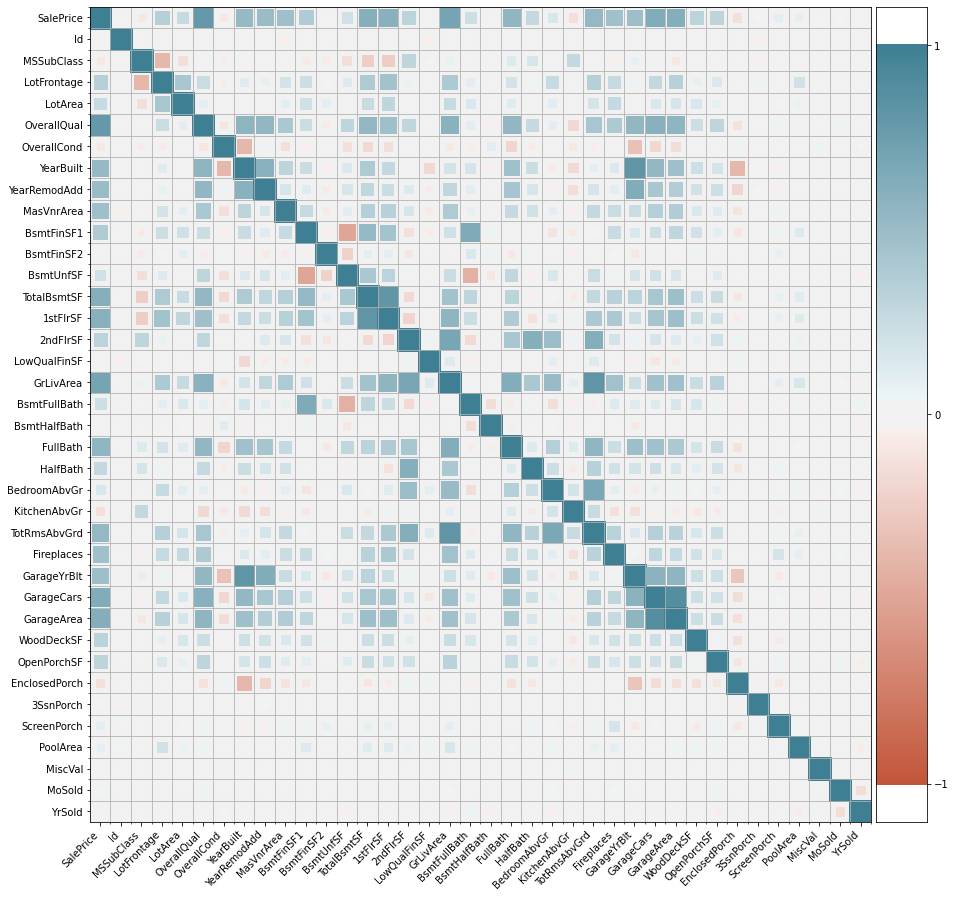

In [5]:
import heatmap
from heatmap import heatmap, corrplot
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 15))
corrplot(pd.concat([train_y,train_x],axis=1).corr())

In [7]:
import aoc
import altair as alt
df = aoc.nan_inspect(train_x).reset_index()
df = df.melt('index', var_name='to', value_name='corr')
plt.figure(figsize=(15, 15))
alt.Chart(df).mark_rect().encode(
    x=alt.X('index:O',sort=alt.EncodingSortField(field="corr", op="sum", order='descending')),
    y=alt.Y('to:O',sort=alt.EncodingSortField(field="corr", op="sum", order='descending')),
    color='corr:Q'
)

1       2
2      16
3     132
4     635
5     501
6      58
7       5
8       5
9      32
10     60
11      7
14      3
15      4
dtype: int64


alt.Chart(...)

<Figure size 1080x1080 with 0 Axes>